# Informe Final Carrera

## 1) Introduccion y consideraciones generales 

Por cuestiones de trabajo tengo la posibilidad de formar parte del equipo de forecast, es por esto que decidi en este informe final de carrera enfocarme mas en explicacion,desarrollo y conclusiones de modelos actuales(un poco mas complejos y diferentes a los vistos hasta ahora) que en el analisis exploratorio de datos. 
Investigando me encontre con que actualmente en el tema de series de tiempo existen diversos modelos de aplicacion( basicamente estan los modelos tradicionales y los de Machine Learning),que responden a diferentes sustentos teoricos y metodologias.

- Los modelos tradicionales tienen la particularidad que tienen un fuerte fundamento teorico, los modelos ARIMA por ejemplo van del modelo teorico a que los datos cumplan esos supuestos y recien ahi se puede aplicar el modelo. Esta forma de encarar los problemas era/es muy comun en la econometria tradicional( vamos de la teoria a los datos) y se suelen tener buenos resultados. 

- Por otro lado los modelos de Machine Learning tiene otro enfoque metodologico, basicamente estos van de los datos a la teoria, es decir tenemos un conjunto de datos realizamos operaciones sobre estos datos y predecimos. La ventaja de esta metodologia es que es mucho mas realista,sin la necesidad del cumplimiento de determinadas hipotesis o requisitos uno puede trabajar y encontrar muy buenas aproximaciones (con la posibilidad de ir iterando continuamente y realizando mejoras).

Habiendo dado un pantallazo muy general sobre estas 2 vertientes de aproximacion voy a pasar a explicar la hoja de ruta de este informe final de carrera.

## 2) Hoja de ruta 

Todo el trabajo esta confeccionado en base a la siguiente pregunta : ¿Existen modelos que mejoren la performance de Random Forest encontrado en el trabajo 3?

Voy a presentar a continuacion la hoja de ruta de este ultimo proyecto:
    
 a)  Link a GitHub. Importacion de librerias y preparar el dataset de manera similar a la realizada en el proyecto 3. ( Esto con el fin de expandir la propuesta de modelos a usar)
    
 b) Cargar el dataframe con los pronosticos obtenidos en el proyecto 3 ( Random Forest) para que sirva de guia.

 c) En este informe se amplia el espectro de modelos agregando 3 nuevas aproximaciones que abarcan la aproximacion mas clasica ( modelos ARIMA y Prophet) y terminando con redes neuronales(NN). A cada uno de estos nuevos modelos voy a citarlos,     realizar una breve explicacion teorica de en que consiste y como funciona para posteriormente modelar y obtener los pronosticos correspondientes.
 
 d) Teniendo los pronosticos de estos 4 modelos, los presento en un dataframe final,incluyendo los errores de cada uno y un ultimo grafico con todos ellos. Me gustaria tambien como conclusion brindar los pros y contras que yo considero de     cada uno de los modelos. 

### 2.a) Importacion de librerias y preparacion del dataset

In [1]:
# Link a GitHub

In [1]:
# Importacion de las librerias a usar
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.layers import Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import acf 
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
import matplotlib
import itertools
import statsmodels.api as sm
from keras.layers.recurrent import LSTM

Importing plotly failed. Interactive plots will not work.


In [2]:
# Creamos el dataset con los 3 años de datos
d_2019 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')
d_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
d_2017 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')

In [3]:
# Concateno los datos de los 3 años
df = pd.concat([d_2017, d_2018, d_2019])
# Filtro para la estacion Illia y pago en efectivo
df = df.loc[(df.estacion =='Illia')&(df.forma_pago == 'EFECTIVO')]
df.head()

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
80,2019,2019-01-01,1,2,Martes,Illia,Centro,Liviano,EFECTIVO,537
86,2019,2019-01-01,1,2,Martes,Illia,Centro,Pesado,EFECTIVO,1
88,2019,2019-01-01,1,2,Martes,Illia,Provincia,Liviano,EFECTIVO,443
94,2019,2019-01-01,1,2,Martes,Illia,Provincia,Pesado,EFECTIVO,1
149,2019,2019-01-01,2,3,Martes,Illia,Centro,Liviano,EFECTIVO,769


In [4]:
df.dtypes

periodo            int64
fecha             object
hora_inicio        int64
hora_fin           int64
dia               object
estacion          object
sentido           object
tipo_vehiculo     object
forma_pago        object
cantidad_pasos     int64
dtype: object

Con dtypes se ve que la naturaleza de las variables son object y enteros pero necesitamos el formato de datetime para poder hacer operaciones relacionadas con el tiempo

In [5]:
# Selecciono sobre que columnas voy a trabajar
df = df[['fecha','hora_fin','dia','sentido','tipo_vehiculo','cantidad_pasos']]

In [6]:
#Creo una columna fecha2 que es la columna fecha en formato datetime, y le unimos la hora_fin como hora usando el timedelta
df['fecha2'] = pd.to_datetime(df.fecha) + pd.to_timedelta(df.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
df.drop(columns=['fecha','hora_fin'], inplace = True)
df.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [7]:
#Reordenamos el dataset por fecha
df.sort_values('fecha2', inplace = True)
df.reset_index(drop=True, inplace = True)

In [8]:
df.dtypes

dia                       object
sentido                   object
tipo_vehiculo             object
cantidad_pasos             int64
fecha2            datetime64[ns]
dtype: object

Ahora si la columna fecha2 esta en formato para trabajar en series de tiempo.

In [9]:
df.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
0,Domingo,Provincia,Pesado,1,2017-01-01
1,Domingo,Provincia,Liviano,9,2017-01-01
2,Domingo,Provincia,Liviano,644,2017-01-01
3,Domingo,Provincia,Pesado,6,2017-01-01
4,Domingo,Provincia,Pesado,1,2017-01-01


Granularidad Semanal

In [10]:
# Resampleo en funcion de las semanas
semanal = df.resample('W' , on = 'fecha2').sum() 
semanal = semanal.loc[(semanal.index > '2017-01-01')]    # elimino la primera fila del dataset
semanal = semanal.loc[(semanal.index < '2020-01-05')]    # elimino la ultima fila del dataset 
semanal.tail()

,cantidad_pasos
fecha2,
2019-12-01,266555
2019-12-08,282891
2019-12-15,272960
2019-12-22,292881
2019-12-29,226390


In [11]:
# Eliminacion de valores atipicos y los reemplazo por la interpolacion de los valores cercanos
semanal.cantidad_pasos[semanal.cantidad_pasos < 230000] = np.nan

In [12]:
print(semanal.isna().sum())
semanal = semanal.interpolate()
print(semanal.isna().sum())

cantidad_pasos    3
dtype: int64
cantidad_pasos    0
dtype: int64


Una vez encontrada la granularidad que considero adecuada para poder trabajar, voy a realizar una descomposicion de la serie. 

Recordando un poco de teoria las series de tiempo tienen implicitas 3 componentes: La tendencia, la estacionalidad y el termino de error. La forma en que estas interactuan es la que va a determinar si el tipo de aproximacion(modelo) que seleccionamos es el adecuado. En este caso como la serie no es expansiva descarte el modelo multiplicativo asi que el modelo sera con granularidad semanal y aditivo, que tiene la particularidad de tener comportamiento "oscilatorio" y relativamente constante alrededor de la tendencia de la serie.

La manera grafica de entender esta interaccion de componentes es usando seasonal_decompose que permite realizar la siguiente interpretacion:

- La primer grafica es la serie original sin cambios, que permite ver a priori una tendencia negativa sin tener un comportamiento explosivo.

- La siguiente grafica es la tendencia que tiene un claro comportamiento negativo( pendiente negativa) lo cual confirma nuestra hipotesis.

- La estacionalidad esta vinculada a si en la serie se observan comportamientos que "se repiten" a lo largo del tiempo, esto es muy comun en ciertos momentos del año, por ejemplo es posible esperar mayor flujo de vehiculos saliendo de     capital a fin de año y en el verano que en otros momentos del año, de darse esta idea la estacionalidad deberia tener ciertos patrones que se repiten. En este caso efectivamente ocurre que todos los años se observan comportamientos similares, tener en cuenta que a pesar de que la serie original tiene tendencia y comportamiento "diferente" a lo largo del tiempo el modelo logra captar una parte estacional.

- Finalmente quedan los residuos que surgen de descomponer la serie en tendencia y estacionalidad, es decir son los valores que no fueron tomados por los anteriores( podria decirse que son los valores que el modelo con granularidad semanal aditivo no logra captar). La idea para definir si el modelo que seleccionamos es adecuado es: Buscamos que los errores se distribuyan alrededor de cero sin ninguna forma particular, esto seria que esten en una franja +- un valor de error. En nuestro caso los errores estan alrededor de cero y considero que tienen un buen comportamiento, entonces el modelo esta captando toda la informacion que necesito.

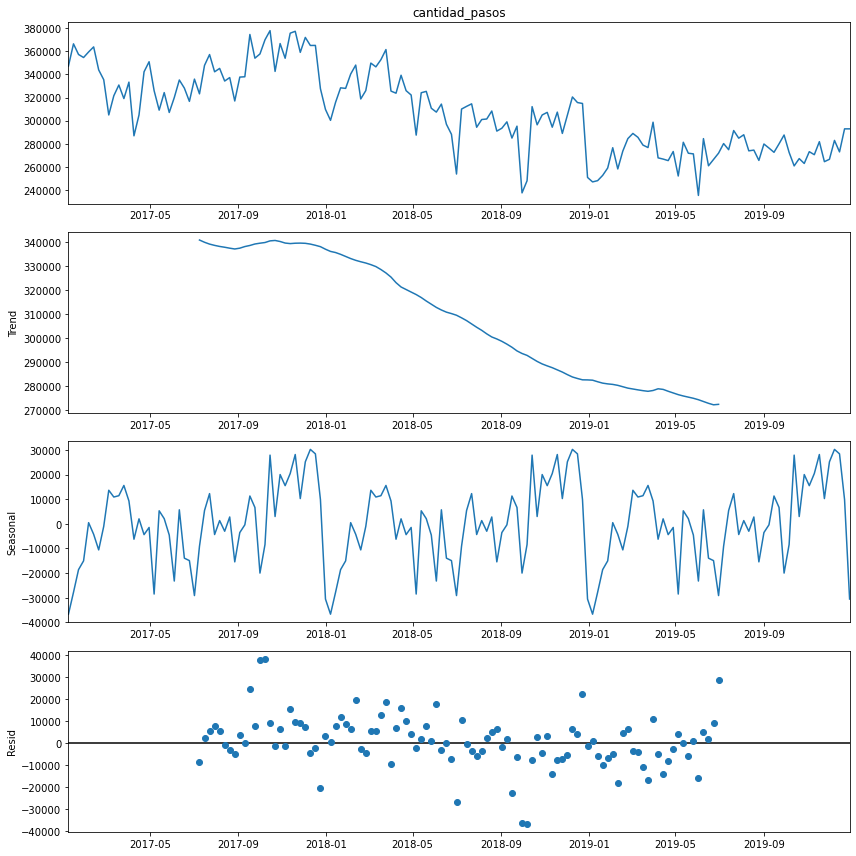

In [13]:
mod_sem_ad = seasonal_decompose(semanal.cantidad_pasos, model='additive')
matplotlib.rcParams['figure.figsize'] = [12,12]
mod_sem_ad.plot()
plt.show()

El siguiente paso es el analisis de autocorrelacion( esta puede ser total o parcial).

Autocorrelacion: Se calcula como covarianza en el rezago k/ varianza, su valor se encuentra entre -1 y 1. Nos indica como esta influenciado el valor de hoy con respecto a de los n periodos anteriores, empieza naturalmente de 1 por que la autocorrelacion del momento t es igual a 1 para ir gradualmente decreciento en t-1 periodos.
El desafio es lograr definir hasta cuando consideramos relevantes los periodos anteriores, esto se logra responder con el grafico de autocorrelacion. En este grafico se contrastan los diferentes periodos anteriores o "lags" y un intervalo de confianza que determina hasta que valor se considera significativo el retardo.
El grafico muestra que hasta el periodo 16 anterior los valores de autocorrelacion estas por fuera de las bandas de confianza, lo que nos va a dar una pauta de que "el valor de hoy esta influenciado por hasta 16 periodos anteriores" en nuestro caso serian 16 semanas o 4 meses de datos.

El analisis de autocorrelacion lo voy a retomar en los modelos ARIMA con mas detalle.

<Figure size 1080x576 with 0 Axes>

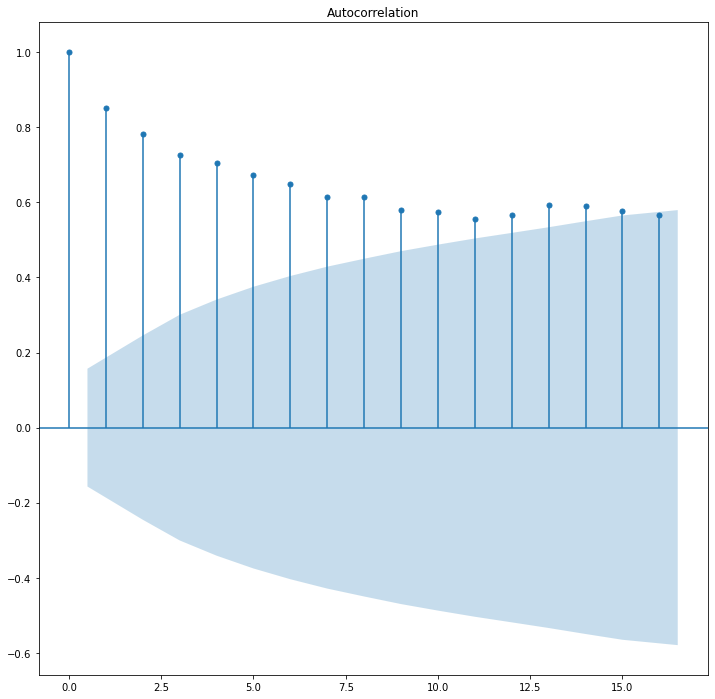

In [14]:
# Grafico de la autocorrelacion con intervalos de confianza
plt.figure(figsize = (15,8))
plot_acf(semanal.cantidad_pasos, lags = 16)
plt.show()

### 2.b) Forecast del proyecto 3

In [15]:
# Creo el diccionario con las columnas y sus respectivos valores 
valores_p3 = {'fecha_2020': ['2020-01-05','2020-01-12','2020-01-19','2020-01-26','2020-02-02','2020-02-09','2020-02-16','2020-02-23','2020-03-01','2020-03-08','2020-03-15','2020-03-22'] , 'Reales' : [150623.0,243359.0,246818.0,241192.0,253335.0,247145.0,261458.0,257096.0,235487.0,254910.0,222793.0,107855.0], 'Predicho' : [269892.865, 274453.865, 275671.27, 272399.635, 275375.98, 275383.915, 276448.185, 274365.155, 275294.52, 273753.63, 274347.83, 273905.175]}

In [16]:
# Creo el dataframe y agrego una nueva columna 'Error' que es la diferencia entre el real y el predicho
df_p3 = pd.DataFrame(valores_p3)
df_p3

,fecha_2020,Reales,Predicho
0,2020-01-05,150623.0,269892.865
1,2020-01-12,243359.0,274453.865
2,2020-01-19,246818.0,275671.270
3,2020-01-26,241192.0,272399.635
4,2020-02-02,253335.0,275375.980
5,2020-02-09,247145.0,275383.915
6,2020-02-16,261458.0,276448.185
7,2020-02-23,257096.0,274365.155
8,2020-03-01,235487.0,275294.520
9,2020-03-08,254910.0,273753.630


### 2.c) Modelado

### MODELO PROPHET

Este modelo fue desarrollado por Facebook y es probablemente el mas facil de usar. Esta basado en un modelo aditivo ( vendria bien para nuestro caso), en la documentacion argumentan que tiene un buen desempeño con datos que tengan un fuerte componente de estacionalidad permitiendo trabajarla a nivel semanal,mensual,anual teniendo en cuenta tambien el efecto de feriados.  

Los pasos para aplicar el modelo son:

1) Transformar la serie de datos con solamente 2 columnas, por un lado las fechas llamadas 'ds' a partir de ahora y los valores 'y' que son los valores de la serie para cada valor de ds

2) Entreno el modelo con .fit decidi en este caso usar estacionalidad anual solamente, el argumento que justifica esta decision es el grafico de seasonal_decompose realizado anteriormente donde veia que mas o menos cada 1 año se veia un comportamiento parecido.

3) Realizar las predicciones y graficar


In [17]:
# Preparo el dataset con ds e y como pide el modelo
prophet = semanal.reset_index()
prophet = prophet.rename( columns = {'fecha2' : 'ds' , 'cantidad_pasos' : 'y'})
prophet.head()

,ds,y
0,2017-01-08,347212.0
1,2017-01-15,366413.0
2,2017-01-22,357215.0
3,2017-01-29,354581.0
4,2017-02-05,359401.0


In [18]:
# Una vez creadas las 2 columnas entreno el modelo, dandole solamente importancia a la estacionalidad anual
p = Prophet(interval_width=0.95,weekly_seasonality=False,daily_seasonality=False, yearly_seasonality=True)
proph = p.fit(prophet)

In [19]:
# Creo el dataframe con los 3 años de datos, y realizo las predicciones sobre los primeros 3 meses del año 2020. 
future_p = p.make_future_dataframe(periods=12,freq='W')
forecast_p = p.predict(future_p)
forecast_p.tail(15)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
153,2019-12-15,261629.892384,258086.751317,318752.721136,261629.892384,261629.892384,26658.844162,26658.844162,26658.844162,26658.844162,26658.844162,26658.844162,0.0,0.0,0.0,288288.736546
154,2019-12-22,261160.865384,243408.645122,310848.123819,261160.865384,261160.865384,15385.838811,15385.838811,15385.838811,15385.838811,15385.838811,15385.838811,0.0,0.0,0.0,276546.704196
155,2019-12-29,260691.838385,225003.429515,292997.971558,260691.838385,260691.838385,-2503.852435,-2503.852435,-2503.852435,-2503.852435,-2503.852435,-2503.852435,0.0,0.0,0.0,258187.985950
156,2020-01-05,260222.811386,209940.493827,276704.950894,260196.904164,260242.429338,-17172.355676,-17172.355676,-17172.355676,-17172.355676,-17172.355676,-17172.355676,0.0,0.0,0.0,243050.455710
157,2020-01-12,259753.784386,204930.800936,268889.168228,259657.612182,259832.888257,-20931.756911,-20931.756911,-20931.756911,-20931.756911,-20931.756911,-20931.756911,0.0,0.0,0.0,238822.027476
158,2020-01-19,259284.757387,210617.308533,279233.043517,259090.330913,259447.227527,-13858.785241,-13858.785241,-13858.785241,-13858.785241,-13858.785241,-13858.785241,0.0,0.0,0.0,245425.972147
159,2020-01-26,258815.730388,222385.255945,286671.561137,258523.050252,259059.100340,-2887.255914,-2887.255914,-2887.255914,-2887.255914,-2887.255914,-2887.255914,0.0,0.0,0.0,255928.474474
160,2020-02-02,258346.703388,230949.471198,293621.511115,257972.238301,258720.227084,4107.942686,4107.942686,4107.942686,4107.942686,4107.942686,4107.942686,0.0,0.0,0.0,262454.646075
161,2020-02-09,257877.676389,226582.218992,295440.138085,257381.750127,258383.468711,3923.077318,3923.077318,3923.077318,3923.077318,3923.077318,3923.077318,0.0,0.0,0.0,261800.753707
162,2020-02-16,257408.649390,221571.527304,287714.758823,256761.431247,258056.136374,-752.069578,-752.069578,-752.069578,-752.069578,-752.069578,-752.069578,0.0,0.0,0.0,256656.579812


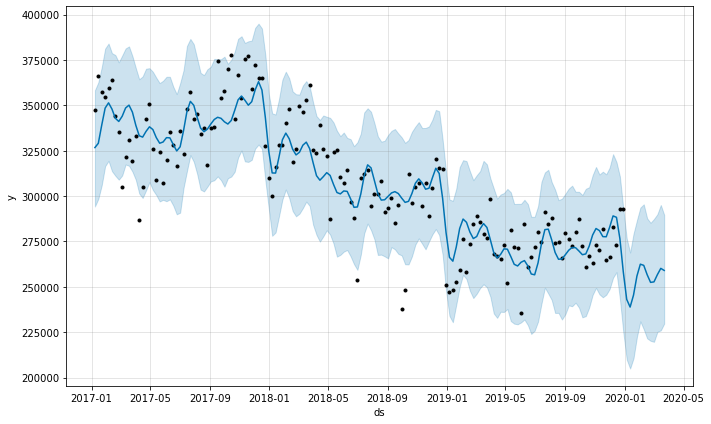

In [20]:
# Grafico sobre la serie 
p_serie = p.plot(forecast_p)

In [21]:
# Como el dataset tiene muchas columnas y yo estoy interesado en el forecast ( yhat) selecciono solamente las fechas y los pronosticos.
df_prophet = forecast_p[['ds','yhat']]
df_prophet = df_prophet.loc[156: ,]
df_prophet

,ds,yhat
156,2020-01-05,243050.455710
157,2020-01-12,238822.027476
158,2020-01-19,245425.972147
159,2020-01-26,255928.474474
160,2020-02-02,262454.646075
161,2020-02-09,261800.753707
162,2020-02-16,256656.579812
163,2020-02-23,252426.451580
164,2020-03-01,252699.029827
165,2020-03-08,256683.721486


### Conclusiones modelo Prophet:

- El modelo devuelve un dataframe con informacion muy util: la tendencia, el termino aditivo y el 'y' pronosticado vienen con sus valores puntuales pero tambien tienen columnas con intervalos de confianza para CADA uno de estos elementos. Esto nos permite poder tener nocion de entre que rangos esperamos que se comporten los distintos componentes.

- El grafico de la serie a lo largo de los tres años permite ver un comportamiento tambien decreciente en tendencia, lo cual es una buena señal de que el modelo esta bien, Prophet formó conjuntos de datos por año: esto quiere decir que si analizamos el grafico para 2017,2018 y 2019 es muy similar en todos lo que varia es la tendencia de los mismos( es decir que el tramo de 2018 por ejemplo es igual al de 2017 pero con marcada pendiente negativa). Esto podria ser muy basico a primera vista pero es una muy buena aproximacion para lograr tener resultados rapidos. Hay que recordar que Prophet esta pensado para gente que no tiene mucho conocimiento en series de tiempo y necesita poder realizar forecast de alguna manera.

- Termine el estudio con un dataframe con los valores pronosticados por Prophet para los primeros 3 meses del año 2020 que luego sera comparado con el resto de modelos.

### MODELO ARIMA

Antes de hablar de los modelos ARIMA es necesario un poco de contexto. La econometria tradicional para la realizacion de forecast trata de tener un sustento teorico para poder modelizar la realidad, en las series de tiempo estos supuestos estan relacionados basicamente al concepto de ESTACIONARIDAD.

La estacionaridad esta relacionado a un concepto matematico referido a la esperanza y varianza de una variable, lo que se busca es que la serie tenga un comportamiento similar a lo largo del tiempo tanto en media como en varianza, esto permite minimizar los efectos de errores o shocks aleatorios que la serie pudiera sufrir a lo largo del tiempo. Si esta constancia se da a traves del tiempo diriamos que la serie es estacionaria que es un pilar fundamental de los modelos de series de tiempo.
Se busca que la serie sea estacionaria para que cambios o modificaciones en valores posteriores sean explicados por el modelo(variables) y no por efectos espurios y/o aleatorios.

La primer pregunta entonces que surge es como vemos si la serie es estacionaria?

- Si se grafica la serie y se observa alguna tendencia(positiva o negativa) lo mas seguro es que no sea constante en media y por lo tanto seria NO estacionaria. En nuestro caso la serie presenta una tendencia negativa por lo tanto podriamos afirmar que es no estacionaria

- Funcion de autocorrelacion parcial: Si el grafico tiene un descenso paulatino de los valores de autocorrelacion de la serie estamos ante una serie NO estacionaria. En este caso nuestra serie tiene este comportamiento, empieza en 1 y tiene un comportamiento decreciente y constante. A su vez con los intervalos de confianza pudimos ver que hasta el rezago 16 era significativo.

- Ya hablando dentro de los modelos ARIMA se puede utilizar el criterio de Akaike-Schwarz para seleccionar el mejor modelo. Por que los modelos ARIMA tienen 3 componentes que pueden ir variando y se tiene que seleccionar un buen modelo, una forma de elegir el mejor modelo seria basado en el criterio de A-S (AIC)

- En econometria una prueba muy comun para determinar la estacionaridad es la prueba de dickey-Fuller que esta vinculada al valor de rho que surge de Yt = rho*Yt-1 + ut , la prueba permite ver si la raiz de rho es unitaria o no, lo cual tambien sirve para afirmar si la serie es estacionaria o no.

Los modelos ARIMA estan compuestos por 3 procesos que interactuan entre si: 

    1) Proceso autoregresivo (AR): Indica que el valor de la serie en el periodo t es igual a los "n" periodos anteriores mas los errores. En nuestro caso con la grafica de autocorrelacion vimos que las valores con retardo 16 tiene impacto significativo en el valor del periodo t.
    
    2) Integrado(I): Definicion vinculada con la estacionaridad de la serie, en general si se toman primeras diferencias la serie se vuelve estacionaria, esto se traduce en serie Integrada de orden 1.
    
    3) Proceso de medias moviles(MA): Este termino esta relacionado al impacto que tienen los errores de periodos anteriores sobre el periodo actual.
    
Entonces el gran desafia es lograr la combinacion AR,I,MA que tengan la mejor performance para realizar el forecast, como se realiza este proceso?
 - Se identifican p,d,q en funcion de los valores y la informacion observada 
 - se realizan las estimaciones
 - Se examinan los resultados( sobre todo residuos)
 - Se realizan pronosticos o se vuelve a un paso anterior.

Entonces el gran desafio en los modelos ARIMA es seleccionar la combinacion p,d,q para obtener un buen forecast.

Voy a empezar en analisis por la componente Integrada.

### Integrada (d): 

La manera mas practica de encontrar el grado de integracion es tomar primeras diferencias, es decir al valor Yt se le resta el Yt-1, y asi sucesivamente y graficar el comportamiento de la serie, por lo generan tomando primeras diferencias o segundas diferencias la serie deberia volverse estacionaria en media.
 
La segunda manera es haciendo un analisis de los correlogramas y como tercera medida tendriamos la prueba de Dickey-Fuller(que no la voy a realizar en este informe) como aproximacion mas precisa.

Con respecto a la varianza lo que se suele hacer es tomar logaritmo, con esto la serie se suaviza y tiene un comportamiento mas uniforme. En nuestro caso como la serie NO es multiplicativa no hace falta realizar esta transformarcion logaritmica pero siempre es una alternativa.

TOMANDO PRIMERAS DIFERENCIAS:

In [22]:
# Cuando trabajamos con series usando .diff podemos calcular la brecha entre los valores de la serie
primera_dif = semanal.diff(periods=1).dropna()
primera_dif.head()

,cantidad_pasos
fecha2,
2017-01-15,19201.0
2017-01-22,-9198.0
2017-01-29,-2634.0
2017-02-05,4820.0
2017-02-12,4373.0


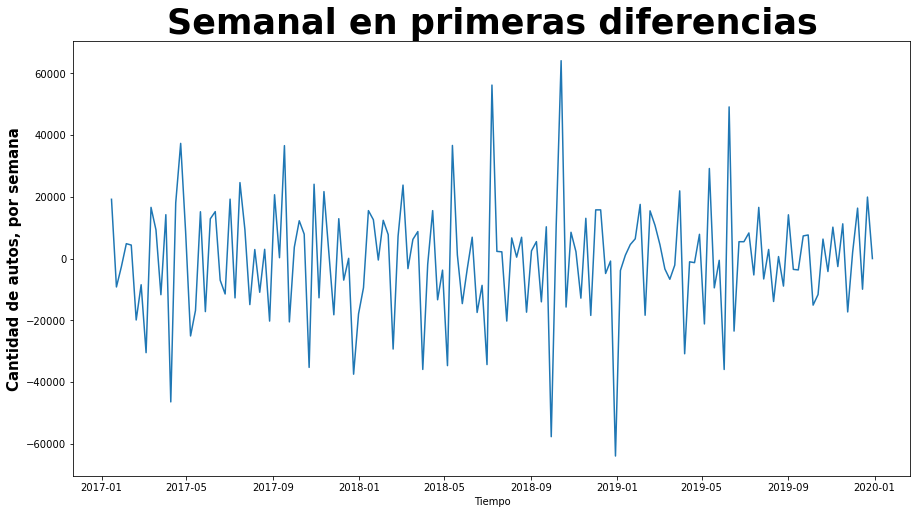

In [23]:
# Grafico la serie
plt.figure(figsize=(15,8))
plt.plot(primera_dif.index, primera_dif.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana' , fontweight = "black" , fontsize = 15)
plt.title("Semanal en primeras diferencias" , fontweight = "black" , fontsize = 35)
plt.show()

In [24]:
# Si quisiera estudiar segundas diferencias:
segunda_dif = semanal.diff(periods=2).dropna()
segunda_dif.head()

,cantidad_pasos
fecha2,
2017-01-22,10003.0
2017-01-29,-11832.0
2017-02-05,2186.0
2017-02-12,9193.0
2017-02-19,-15524.0


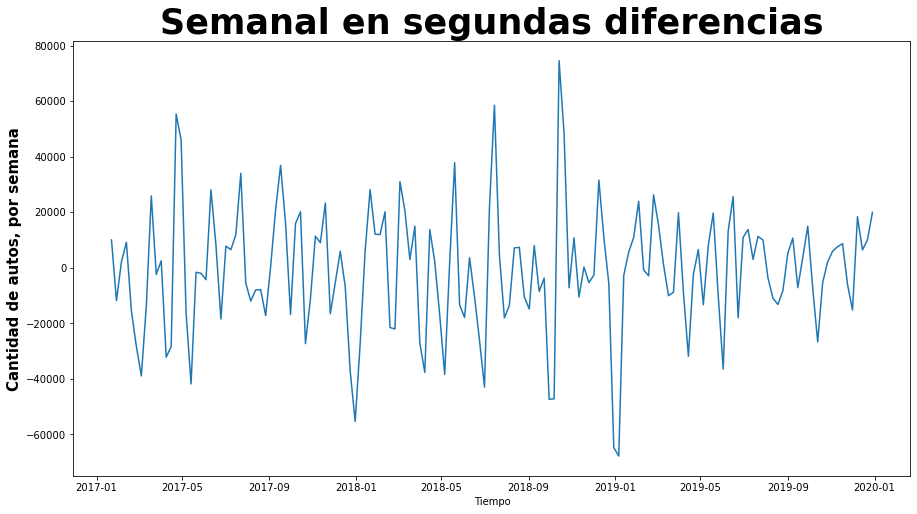

In [25]:
# Grafico la serie
plt.figure(figsize=(15,8))
plt.plot(segunda_dif.index, segunda_dif.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana' , fontweight = "black" , fontsize = 15)
plt.title("Semanal en segundas diferencias" , fontweight = "black" , fontsize = 35)
plt.show()

ANALIZANDO CORRELOGRAMAS:

- La mecanica es ver el comportamiento de los rezagos de la serie diferenciada.

- Ver el comportamiento de los rezagos( si estan dentro o fuera del intervalo de confianza 95%)

<Figure size 360x360 with 0 Axes>

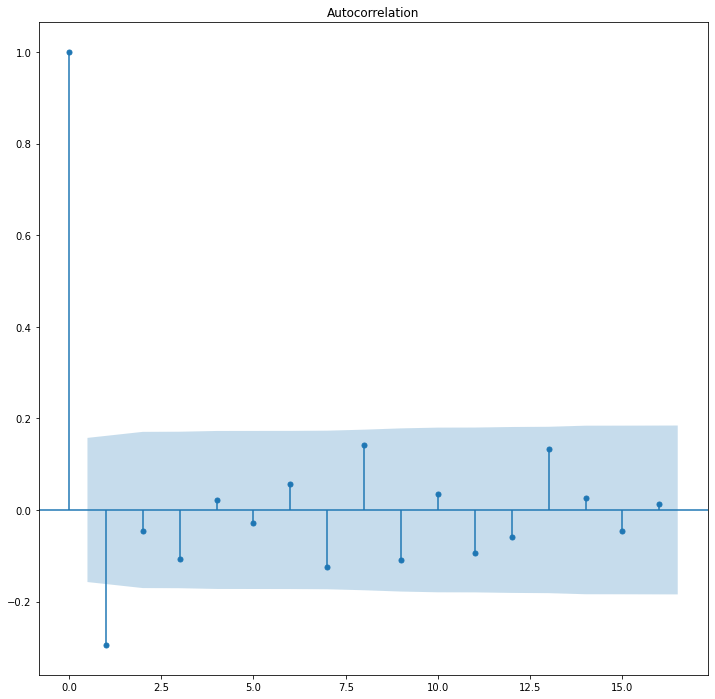

In [26]:
# Grafico de la autocorrelacion con intervalos de confianza
plt.figure(figsize = (5,5))
plot_acf(primera_dif.cantidad_pasos, lags = 16)

plt.show()

CONCLUSIONES COMPONENTE INTEGRADA:
    
- Como se pueden ver en los  graficos anteriores de primeras diferencias, al aplicarle primeras y segundas diferencias a la serie la transformamos en estacionaria, es decir que confirmamos que la serie tiene componente Integrada = 1 o 2.

- Como graficamente estamos en la duda de si es d=1 o d=2 con el grafico de autocorrelacion esa duda queda eliminada, el autocorrelograma muestra 2 rezagos por fuera del intervalo de confianza, por lo tanto la serie es integrada de orden 2.

- Se puede tomar 2 caminos, por un lado puedo tomar la serie original que sea ARIMA completa con d=2 o tambien esta la opcion de trabajar con la serie ya diferenciada y simplemente a esa serie encontrar la componente p y q(es decir sobre la serie diferenciada quedaria un modelo ARMA)

### AUTOREGRESIVO(p) Y MEDIAS MOVILES(q):

La componente AR(p) es cuantos periodos para atras tomo para explicar los nuevos valores y la componente MA(q) esta relacionado con los periodos en media movil(vinculada con los errores de periodos anteriores)

La mejor forma para abordar estas segundas 2 componentes es realizando diferentes combinaciones AR,MA que tengan una autocorelacion de errores total adecuada(es decir que en el grafico tendrian que ecnontrarse todos los valores dentro del intervalo de confianza del 95%). 

La segunda forma de seleccionar estas componentes va a ser realizando combinatorias para diferentes valores y comparando los valores de Akaike-Schwarz( Prueba de bondad de ajuste).

Una buena primera aproximacion es recordar esta informacion que tenemos a priori. Calculamos que hasta el periodo 16 incluse anterior tienen efectos sobre el periodo actual( es probable que los valores AR esten rondando ese numero) , por el lado de medias moviles en el proyecto 3 el numero ronda los 4. Si bien no hay ninguna razon para que el mejor modelo si o si cumpla con estos valores seria deseable que fueran valores cercanos.

### MODELADO:

En este punto decidi tomar 2 caminos, por un lado realizar un modelo ARIMA tradicional y por otro lado un SARIMA( similar a un ARIMA solo que tiene en cuenta estacionalidad) que en teoria deberia tener mejor performance. 

Voy a realizar una combinatoria exactamente sobre los mismos rangos de p,q,d y le voy a calcular el Akaike-Schwarz a cada modelo y quedarme con el que mejor resultado tenga(Deberia ser el SARIMA)

In [27]:
# Defino la variable y tanto para el ARIMA como el SARIMA
y_arima = semanal
y_arima.tail(15)

,cantidad_pasos
fecha2,
2019-09-22,279927.0
2019-09-29,287568.0
2019-10-06,272483.0
2019-10-13,260840.0
2019-10-20,267147.0
2019-10-27,262950.0
2019-11-03,273129.0
2019-11-10,270536.0
2019-11-17,281790.0


CAMINO A

En la siguiente celda lo que hago es crear los rangos de variacion de p,d,q en funcion de todas las consideraciones realizadas hasta el momento. Realice una primer corrida con:
   
   - p=range(10,16) , d=range(1,3) y q=range(1,3) tanto en la componente ARIMA como en el modelo estacional  para ver todas las posibles combinaciones y quedarme con la que tenga menor valor de Akaike-Schwarz
   
Luego de esa corrida selecciono el que considero es el mejor modelo y lo entreno con esos valores de p,d,q puntuales para ver su comportamiento 
   

In [28]:
p = range(10, 16)
d = range(1,3)
q = range(1,3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('SARIMA combinatoria')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

SARIMA combinatoria
SARIMAX: (10, 1, 2) x (10, 1, 2, 12)
SARIMAX: (10, 1, 2) x (10, 2, 1, 12)
SARIMAX: (10, 2, 1) x (10, 2, 2, 12)
SARIMAX: (10, 2, 1) x (11, 1, 1, 12)


In [29]:
# Recomiendo no correr esta serie por su prolongada duracion( En caso de querer hacerlo por favor descomentar la lectura)
'''
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            sarima = sm.tsa.statespace.SARIMAX(y_arima,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            sarima_resultados = sarima.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, sarima_resultados.aic))
        except:
            continue '''

"\nfor param in pdq:\n    for param_seasonal in seasonal_pdq:\n        try:\n            sarima = sm.tsa.statespace.SARIMAX(y_arima,\n                                            order=param,\n                                            seasonal_order=param_seasonal,\n                                            enforce_stationarity=False,\n                                            enforce_invertibility=False)\n\n            sarima_resultados = sarima.fit()\n\n            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, sarima_resultados.aic))\n        except:\n            continue "

In [30]:
# Realizo la estimacion con los valores puntuales de p,d y q y los expreso en una tabla
SARIMA = sm.tsa.statespace.SARIMAX(y_arima,order=(10, 1, 1),seasonal_order=(10, 1, 1, 12),enforce_stationarity=False,enforce_invertibility=False)
SARIMA_results = SARIMA.fit()

C:\Users\Luciano\miniconda3\envs\keras\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [31]:
# Valor de bondad de ajuste Akaike-Schwarz que nos servira para comparar con el ARIMA
SARIMA_results.aic

333.33742645846235

CAMINO B

El camino B es un poco mas simple por que no tiene la parte de estacionalidad, por lo tanto se tiene resultados de manera mas rapida.

Lo que hice fue seguir los mismos pasos que el en camino A, hasta llegar al Akaike-Schwarz para tener asi una comparativa sobre cual es el mejor modelo.

In [32]:
p2 = range(10, 16)
d2 = range(1,3)
q2 = range(1,3)
pdq2 = list(itertools.product(p2, d2, q2))
print('ARIMA combinatoria')
print('ARIMA: {}'.format(pdq2[1]))
print('ARIMA: {}'.format(pdq2[1]))
print('ARIMA: {}'.format(pdq2[2]))
print('ARIMA: {}'.format(pdq2[2]))

ARIMA combinatoria
ARIMA: (10, 1, 2)
ARIMA: (10, 1, 2)
ARIMA: (10, 2, 1)
ARIMA: (10, 2, 1)


In [33]:
# Al igual que el for para SARIMA esta celda tarda mucho tiempo en correr
'''
for parametros2 in pdq2:
    try:
            arima = sm.tsa.arima.ARIMA(y_arima,
                                            order=parametros2,                                        
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            arima_fit = arima.fit()

            print('ARIMA{} - AIC:{}'.format(parametros2,arima_fit.aic))
    except:
            continue'''

"\nfor parametros2 in pdq2:\n    try:\n            arima = sm.tsa.arima.ARIMA(y_arima,\n                                            order=parametros2,                                        \n                                            enforce_stationarity=False,\n                                            enforce_invertibility=False)\n\n            arima_fit = arima.fit()\n\n            print('ARIMA{} - AIC:{}'.format(parametros2,arima_fit.aic))\n    except:\n            continue"

In [34]:
# Entreno el modelo ARIMA con los mismos valores que el SARIMA
ARIMA = sm.tsa.arima.ARIMA(y_arima,order=(10,1,1),enforce_stationarity=False,enforce_invertibility=False)
ARIMA_results = ARIMA.fit()
#print(ARIMA_results.summary().tables[1])

In [35]:
# El Akaike-Schwarz da un valor muy superior al de SARIMA
ARIMA_results.aic

3257.997452548878

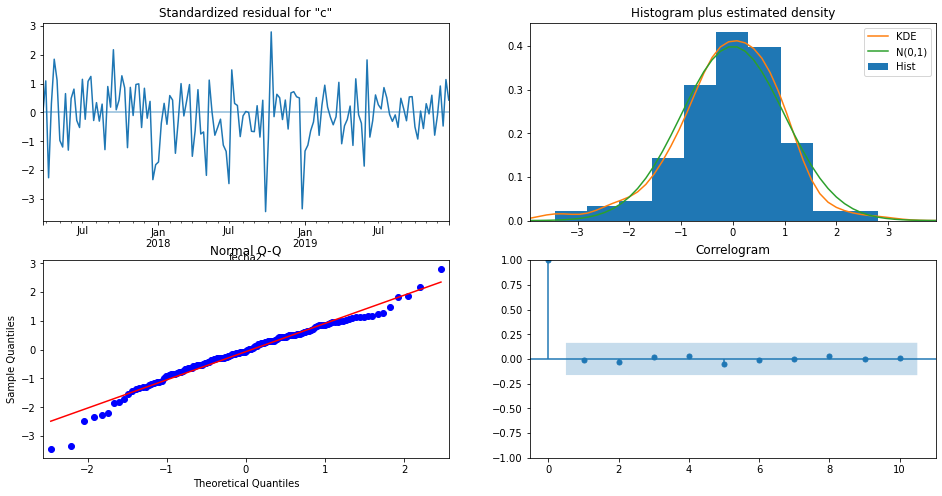

In [36]:
ARIMA_results.plot_diagnostics(figsize=(16, 8))
plt.show()

Podemos ver que los residuos estan estandarizados, el correlograma de los errores tiene una distribucion bastante similar a la normal ( tambien que confirma esto con el Q-Q plot de normalidad) por lo que los residuos del modelo se comportan bien y es un potencial modelo para pronosticar valores de una serie

In [37]:
SARIMA_pred = SARIMA_results.forecast(steps=16)
print(SARIMA_pred)

2020-01-05    293735.338671
2020-01-12    287582.363972
2020-01-19    312018.620466
2020-01-26    338290.588850
2020-02-02    333162.940099
2020-02-09    297833.408106
2020-02-16    330025.522280
2020-02-23    310918.796342
2020-03-01    308536.326694
2020-03-08    288123.246456
2020-03-15    306590.432743
2020-03-22    340820.899763
2020-03-29    353530.130278
2020-04-05    323513.971244
2020-04-12    311025.902514
2020-04-19    336717.526958
Freq: W-SUN, Name: predicted_mean, dtype: float64


In [38]:
ARIMA_pred = ARIMA_results.forecast(steps=12)
print(ARIMA_pred)

2020-01-05    285193.165837
2020-01-12    283650.936328
2020-01-19    280089.101084
2020-01-26    279379.516288
2020-02-02    282289.193736
2020-02-09    278182.346602
2020-02-16    279788.485044
2020-02-23    278438.517120
2020-03-01    277154.429598
2020-03-08    277831.717601
2020-03-15    278478.744030
2020-03-22    278882.702416
Freq: W-SUN, Name: predicted_mean, dtype: float64


### Conclusiones modelos SARIMA-ARIMA:

- Este modelo puede ser mucho mas tedioso y complicado que el modelo anterior pues requiere realizar algunas acciones antes de poder realizar el Forecast. El modelo SARIMA si bien tiene mayor precision y complejidad a la hora de realizar el forecast obtuvo un pesimo desempeño comparado al ARIMA, de hecho la tendencia del modelo SARIMA entra en contradiccion con la serie original. Por lo tanto la primer conclusion es que si bien el SARIMA deberia ser mejor teoricamente a la hora de pronosticar el modelo ARIMA es muy superior y es el elegido.
 
- Las predicciones tienen un comportamiento bastante suavizado y estable, es decir que si bien el forecast tiene tendencia es muy suave (pareciera ser tambien estacionario) lo cual puede provocar grandes errores a la hora de implementar este modelo.

- Si se perfecciona la tecnica y la implementacion de este modelo puede ser una muy buena alternativa, el problema es el tiempo; en mi caso estuve practicamente 12 horas corriendo 3 celdas para poder seleccionar correctamente las componentes p,d,q lo que hace poco practico esta implementacion.

## MODELO NN

Los modelos de redes neuronales estan dentro de los llamados modelos de Deep Learning, la idea central de este tipo de modelos es que se tienen 3 "capas" o fases, la primera de entrada es la que recibe los inputs, la segunda capa denominada capa oculta(que es donde interactual las neuronas a traves de operaciones lineales y no lineales con diferentes grados de complejidad) y una tercera capa de output con toda la informacion de salida luego del proceso de interaccion.


En los modelos de Deep Learning los elementos mas importantes son los pesos y el sesgo. El peso esta relacionado a la influencia(pendiente) que tiene esa feature sobre la original, y por otro lado esta el sesgo que en un modelo lineal esta asociado a la ordenada al origen. En este tipo de modelos al igual que los clasicos de ML que vimos, la idea es tratar de minimizar el error (loss) en los problemas de regresion.

La idea central es que en cada capa, las neuronas tomen los distintos pesos y sesgos traten de minimizarlos y devuelvan un output, la neurona de la siguiente capa toma esos pesos y sesgos para nuevamente operar bajo la misma consigna, esto se realiza hasta completar todas las capas y generar el output final. Un concepto que esta intimamente relacionado con la neurona es la funcion de activacion que es basicamente una funcion indicadora que vale 0 o 1 si se cumple o no determinadas condiciones que da o no "permiso" a que esa neurona pase informacion a la siguiente capa y permite la no-linealidad.

La libreria Keras usa como insumo Numpy Array de basicamente 3 dimensiones(llamados tensores): 
    - Ejes: que pueden ser vectores o matrices
    - Forma: Cuantas dimensiones tiene cada eje
    - tipo de datos: Int, float,etc
    
Basta con definir el tensor inicial y el modelo va haciendo los calculos para las posteriores capas. Cabria esperar que a medida que aumenten las epocas(que indican el número de veces que usaremos todos los datos en el proceso de aprendizaje y su constante mejora)

Existen un monton de parametros e hiperparametros para tener en cuenta en los modelos de redes neuronales, pero por ser una primera aproximacion voy a tratar de hacer el modelo mas simple posible.

Pasos:
    1) Separacion la serie en Train y Test, tome el año 2017 y 2018 para train y 2019 para test
    2) Reescalado de la serie en el intervalo -1,1 antes de incluir variables rezagadas, componentes de tendencia y estacionalidad como neuronas de entrada 
    3) Contruccion del modelo con parametros e hiperparametros mas comunes
    4) Corrida del modelo para las distintas epocas y calculo de las perdidas
    5) Encuentro las y predichas y comparo con las de test

In [39]:
df_nn = semanal#.set_index(['fecha2'])#drop=True)
df_nn

,cantidad_pasos
fecha2,
2017-01-08,347212.0
2017-01-15,366413.0
2017-01-22,357215.0
2017-01-29,354581.0
2017-02-05,359401.0
...,...
2019-12-01,266555.0
2019-12-08,282891.0
2019-12-15,272960.0


In [40]:
# Separo los datos en Enero de 2019
split_date = pd.Timestamp('2019-01-05')

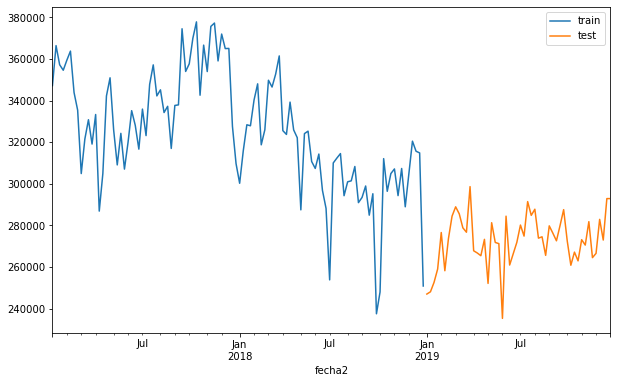

In [41]:
# Del dataset en granularidad semanal tomo la columna cantidad de pasos y la separo en train y test. Luego grafico
df_nn =  semanal['cantidad_pasos']
train = df_nn.loc[:split_date]  # Train va desde el dato 1 hasta el punto de split
test = df_nn.loc[split_date:]   # los datos de test van desde el punto de split hasta el final
plt.figure(figsize=(10, 6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);

In [42]:
# El shape de train es igual a 104( equivalente a 2 años de datos en semanas)
train

fecha2
2017-01-08    347212.0
2017-01-15    366413.0
2017-01-22    357215.0
2017-01-29    354581.0
2017-02-05    359401.0
                ...   
2018-12-02    304707.5
2018-12-09    320481.0
2018-12-16    315645.0
2018-12-23    314832.0
2018-12-30    250861.0
Freq: W-SUN, Name: cantidad_pasos, Length: 104, dtype: float64

In [43]:
# El shape de test es un año(52 semanas)
test.shape

(52,)

In [44]:
# Realizo un escalado entre -1 y 1 de los valores de train y de test
scaler = MinMaxScaler(feature_range=(-1, 1))
train_sc = scaler.fit_transform(train.values.reshape(-1,1))
test_sc = scaler.transform(test.values.reshape(-1,1))

In [45]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [46]:
# Instancio el objeto Sequential
nn_model = Sequential()
nn_model.add(Dense(10, input_dim=1, activation='sigmoid')) # 
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = nn_model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=1,callbacks=[early_stop], shuffle=False) # usamos train y test, 50 epocas o vueltas completas. Bloques de a 1

Epoch 1/50
103/103 [==============================] - 0s 651us/step - loss: 0.1924
Epoch 2/50
103/103 [==============================] - 0s 583us/step - loss: 0.1288
Epoch 3/50
103/103 [==============================] - 0s 524us/step - loss: 0.1268
Epoch 4/50
103/103 [==============================] - 0s 505us/step - loss: 0.1205
Epoch 5/50
103/103 [==============================] - 0s 515us/step - loss: 0.1144
Epoch 6/50
103/103 [==============================] - 0s 505us/step - loss: 0.1088
Epoch 7/50
103/103 [==============================] - 0s 2ms/step - loss: 0.1039
Epoch 8/50
103/103 [==============================] - 0s 544us/step - loss: 0.0996
Epoch 9/50
103/103 [==============================] - 0s 524us/step - loss: 0.0958
Epoch 10/50
103/103 [==============================] - 0s 505us/step - loss: 0.0926
Epoch 11/50
103/103 [==============================] - 0s 476us/step - loss: 0.0899
Epoch 12/50
103/103 [==============================] - 0s 505us/step - loss: 0.0877
Epo

Los valores de perdida estan en torno a 0.070 casi de manera estable. Esta cifra es bastante superior a otras que encontre investigando( No logre reducir este valor por falta de dominio en el tema). De todas maneras realizo las pruebas de R2 en train y test y los errores

In [47]:
y_pred_test_nn = nn_model.predict(X_test)
y_train_pred_nn = nn_model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))

The R2 score on the Train set is:	0.539
The R2 score on the Test set is:	-0.608


Obtuve un R2 muy bajo en Train y un valor irrisorio en Test, razon por la cual decidi no seguir avanzando con este modelo ya que no tengo los en este momento los conocimientos suficientes para tratar de mejorar la perfomance de este modelo. Sin embargo queria dejar asentado los conocimientos teoricos que tengo sobre el mismo asi como una primera incursion. Es un tema que me interesa mucho asi que seguramente seguire estudiando y aprendiendo mas sobre Deep Learning.

### Conclusiones REDES NEURONALES:

- Sin dudas el modelo mas dificil, tiene muchas opciones y elementos a tener en cuenta para tener una buena aproximacion.

- En mi caso no cuento con el nivel suficiente para lograr realizar el forecast para este modelo, sin embargo trate de llegar al punto mas lejano posible y aprender todo lo que pude de este modelo.

- Voy a dejar el modelo de redes neuronales en este punto y de aca en adelante no entraran en la comparativa y en las conclusiones finales.

### 2.d) Presentacion DataFrame final, comparaciones,evaluaciones y conclusiones

Formalmente el dataset con los pronosticos a traves de los diferentes modelos queda expresada de esta forma:

In [48]:
# Creo un diccionario con toda la informacion pertinente
valores_finales = {'FECHAS': [ '2020-01-05','2020-01-12','2020-01-19','2020-01-26','2020-02-02','2020-02-09','2020-02-16','2020-02-23','2020-03-01','2020-03-08','2020-03-15','2020-03-22'] , 
                   'REALES' : [150623.0,243359.0,246818.0,241192.0,253335.0,247145.0,261458.0,257096.0,235487.0,254910.0,222793.0,107855.0], 
                   'RF' : [269892.865, 274453.865, 275671.27, 272399.635, 275375.98, 275383.915, 276448.185, 274365.155, 275294.52, 273753.63, 274347.83, 273905.175],
                   'PROPHET' : [243050.4557,238822.027,245425.97,255928.47,262454.64,261800.75,256656.57,252426.45,252699.02,256683.72,260147.97,259001.0],
                   'ARIMA' : [285193.16,283650.93,280089.10,279379.51,282289.19,278182.34,279788.48,278438.51,277154.42,277831.71,278478.74,278882.70]}

In [49]:
# Creo el dataframe con los valores para las diferentes fechas
df_pronosticos = pd.DataFrame(valores_finales)
df_pronosticos

,FECHAS,REALES,RF,PROPHET,ARIMA
0,2020-01-05,150623.0,269892.865,243050.4557,285193.16
1,2020-01-12,243359.0,274453.865,238822.0270,283650.93
2,2020-01-19,246818.0,275671.270,245425.9700,280089.10
3,2020-01-26,241192.0,272399.635,255928.4700,279379.51
4,2020-02-02,253335.0,275375.980,262454.6400,282289.19
5,2020-02-09,247145.0,275383.915,261800.7500,278182.34
6,2020-02-16,261458.0,276448.185,256656.5700,279788.48
7,2020-02-23,257096.0,274365.155,252426.4500,278438.51
8,2020-03-01,235487.0,275294.520,252699.0200,277154.42
9,2020-03-08,254910.0,273753.630,256683.7200,277831.71


Interpretacion grafica de las series:

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

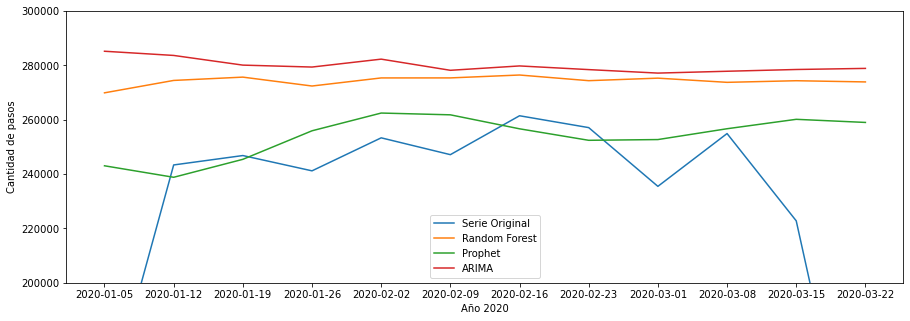

In [50]:
plt.figure(figsize = (15,5))
plt.plot(df_pronosticos.FECHAS, df_pronosticos.REALES, label = 'Serie Original')
plt.plot(df_pronosticos.FECHAS, df_pronosticos.RF, label = 'Random Forest')
plt.plot(df_pronosticos.FECHAS, df_pronosticos.PROPHET, label = 'Prophet')
plt.plot(df_pronosticos.FECHAS, df_pronosticos.ARIMA, label = 'ARIMA')
plt.legend()
plt.xlabel('Año 2020')
plt.ylabel('Cantidad de pasos')
plt.ylim(200000,300000)          # si esta comentado muestra el valor outlier
plt.show()

Graficamente la serie del modelo Prophet pareciera ser la que mejor se aproxima a los valores de la serie original, para confirmar esta hipotesis voy a calcular los distintos errores 

In [51]:
df_pronosticos['MSE_RF'] = ((df_pronosticos['RF'] - df_pronosticos['REALES']) ** 2).mean()
df_pronosticos['RMSE_RF'] = np.sqrt(df_pronosticos['MSE_RF'])
df_pronosticos['mse_PROPHET'] = ((df_pronosticos['PROPHET'] - df_pronosticos['REALES']) ** 2).mean()
df_pronosticos['RMSE_PROPHET'] = np.sqrt(df_pronosticos['mse_PROPHET'])
df_pronosticos['mse_ARIMA'] = ((df_pronosticos['ARIMA'] - df_pronosticos['REALES']) ** 2).mean()
df_pronosticos['RMSE_ARIMA'] = np.sqrt(df_pronosticos['mse_ARIMA'])
df_pronosticos = df_pronosticos[['FECHAS','REALES','RF','PROPHET','ARIMA','RMSE_RF','RMSE_PROPHET','RMSE_ARIMA']]
df_pronosticos

,FECHAS,REALES,RF,PROPHET,ARIMA,RMSE_RF,RMSE_PROPHET,RMSE_ARIMA
0,2020-01-05,150623.0,269892.865,243050.4557,285193.16,65176.089451,52966.376182,70417.768182
1,2020-01-12,243359.0,274453.865,238822.0270,283650.93,65176.089451,52966.376182,70417.768182
2,2020-01-19,246818.0,275671.270,245425.9700,280089.10,65176.089451,52966.376182,70417.768182
3,2020-01-26,241192.0,272399.635,255928.4700,279379.51,65176.089451,52966.376182,70417.768182
4,2020-02-02,253335.0,275375.980,262454.6400,282289.19,65176.089451,52966.376182,70417.768182
5,2020-02-09,247145.0,275383.915,261800.7500,278182.34,65176.089451,52966.376182,70417.768182
6,2020-02-16,261458.0,276448.185,256656.5700,279788.48,65176.089451,52966.376182,70417.768182
7,2020-02-23,257096.0,274365.155,252426.4500,278438.51,65176.089451,52966.376182,70417.768182
8,2020-03-01,235487.0,275294.520,252699.0200,277154.42,65176.089451,52966.376182,70417.768182
9,2020-03-08,254910.0,273753.630,256683.7200,277831.71,65176.089451,52966.376182,70417.768182


Finalmente con ese ultimo DataFrame podemos concluir que el error del modelo Prophet es el menor asi que seria el indicado para realizar el mejor forecast posible.

### Pros y contras de cada  modelo:
 - Pros Prophet:
        - Facil de implementar
        - Increiblemente bueno y preciso
 -Contras Prophet: 
        - No queda claro que hace el algoritmo internamente
        - Imposibilidad de controlar el error
 - Pros ARIMA/SARIMA:
        - Modelo muy completo y complejo
        - Permite tener control sobre todas(o casi todas) las variables intervinientes
        - Se tiene buen control sobre el error y su magnitud
 - Contras ARIMA/SARIMA:
        - Demanda mucho tiempo en la confeccion del modelo
        - El coeficiente Akaike-Schwarz no siempre es util en la practica
 - Pros Redes Neuronales:
         - Probablemente sean hoy por hoy los mejores modelos para predecir dado su alto poder de abstraccion
         - Permite ir y venir en el proceso, tiene muchos parametros e hiperparametros que se pueden ir ajustando para lograr un buen desempeño
 - Contras Redes Neuronales:
         - Tienen una estructura compleja, tanto a nivel conceptual como a nivel practico
         - La confeccion del modelo puede tomar mucho tiempo
         - No apto para todo el mundo 
         - Requiere mucha cantidad de datos